# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [51]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
import warnings
warnings.filterwarnings("ignore")
import itertools

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [52]:
# Define a function to load data and aggregate them

def load_and_aggregate_stock_data(file_list):
    combined_df = pd.DataFrame()

    for file in file_list:
        stock_name = os.path.basename(file).split('_')[0]
        df = pd.read_csv(file)
        df['Stock'] = stock_name
        
        df.drop(columns=['Name'], inplace=True)
        combined_df = pd.concat([combined_df, df], ignore_index=True)
       
    return combined_df
    

In [53]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

file_list = [
    "./RNN_Stocks_Data/AMZN_stocks_data.csv",
    "./RNN_Stocks_Data/GOOGL_stocks_data.csv",
    "./RNN_Stocks_Data/IBM_stocks_data.csv",
    "./RNN_Stocks_Data/MSFT_stocks_data.csv"
]

all_stocks_df = load_and_aggregate_stock_data(file_list)


In [54]:
# View specifics of the data
print(all_stocks_df.head())
print(all_stocks_df.tail())


print(all_stocks_df.info())
print(all_stocks_df.describe())


# Number of rows per stock
print(all_stocks_df['Stock'].value_counts())

# Check date range for each stock
print(all_stocks_df.groupby('Stock')['Date'].agg(['min', 'max']))

         Date   Open   High    Low  Close   Volume Stock
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN
             Date   Open   High    Low  Close    Volume Stock
12072  2017-12-22  85.40  85.63  84.92  85.51  14145841  MSFT
12073  2017-12-26  85.31  85.53  85.03  85.40   9891237  MSFT
12074  2017-12-27  85.65  85.98  85.22  85.71  14678025  MSFT
12075  2017-12-28  85.90  85.93  85.55  85.72  10594344  MSFT
12076  2017-12-29  85.63  86.05  85.50  85.54  18717406  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  f

In [55]:
# Handling Extra row in IBM data. 

ibm_dates = set(all_stocks_df[all_stocks_df['Stock'] == 'IBM']['Date'])
amzn_dates = set(all_stocks_df[all_stocks_df['Stock'] == 'AMZN']['Date'])
googl_dates = set(all_stocks_df[all_stocks_df['Stock'] == 'GOOGL']['Date'])
msft_dates = set(all_stocks_df[all_stocks_df['Stock'] == 'MSFT']['Date'])


extra_ibm_dates = ibm_dates - (amzn_dates & googl_dates & msft_dates)
print("Extra date in IBM data:", extra_ibm_dates)


# Dropping the row 
all_stocks_df.drop(
    all_stocks_df[(all_stocks_df['Stock'] == 'IBM') & (all_stocks_df['Date'].isin(extra_ibm_dates))].index,
    inplace=True
)

#verifying data
print(all_stocks_df['Stock'].value_counts())

Extra date in IBM data: {'2010-04-01'}
Stock
AMZN     3019
GOOGL    3019
IBM      3019
MSFT     3019
Name: count, dtype: int64


In [56]:
#converting Date column type from object to datetime
all_stocks_df['Date'] = pd.to_datetime(all_stocks_df['Date'])

print(all_stocks_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 12076 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12076 non-null  datetime64[ns]
 1   Open    12075 non-null  float64       
 2   High    12076 non-null  float64       
 3   Low     12075 non-null  float64       
 4   Close   12076 non-null  float64       
 5   Volume  12076 non-null  int64         
 6   Stock   12076 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 754.8+ KB
None


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [57]:
# Handle Missing Values

print(all_stocks_df.isnull().sum())

#checking for missing rows
print("-------------------------------------------------------")
missing_rows = all_stocks_df[all_stocks_df.isnull().any(axis=1)]
print(missing_rows)


#inspecting previous and next date for IBM data
print("-------------------------------------------------------")
ibm_df = all_stocks_df[all_stocks_df['Stock'] == 'IBM']
print(ibm_df[ibm_df['Date'].between('2017-07-28', '2017-08-01')])


# Sort first by stock and date
all_stocks_df.sort_values(by=['Stock', 'Date'], inplace=True)

# Use linear interpolation for imputing values
all_stocks_df.interpolate(method='linear', inplace=True)

print("-------------------------------------------------------")
#verifying imputed values
print(all_stocks_df[(all_stocks_df['Stock'] == 'IBM') & (all_stocks_df['Date'] == '2017-07-31')])

print("-------------------------------------------------------")
# verifying missing values 
print(all_stocks_df.isnull().sum())


Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Stock     0
dtype: int64
-------------------------------------------------------
           Date  Open    High  Low   Close   Volume Stock
8951 2017-07-31   NaN  144.93  NaN  144.67  4355718   IBM
-------------------------------------------------------
           Date    Open    High     Low   Close   Volume Stock
8950 2017-07-28  144.81  145.04  143.84  144.29  3054834   IBM
8951 2017-07-31     NaN  144.93     NaN  144.67  4355718   IBM
8952 2017-08-01  145.00  145.67  144.72  145.30  3219477   IBM
-------------------------------------------------------
           Date     Open    High     Low   Close   Volume Stock
8951 2017-07-31  144.905  144.93  144.28  144.67  4355718   IBM
-------------------------------------------------------
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Stock     0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

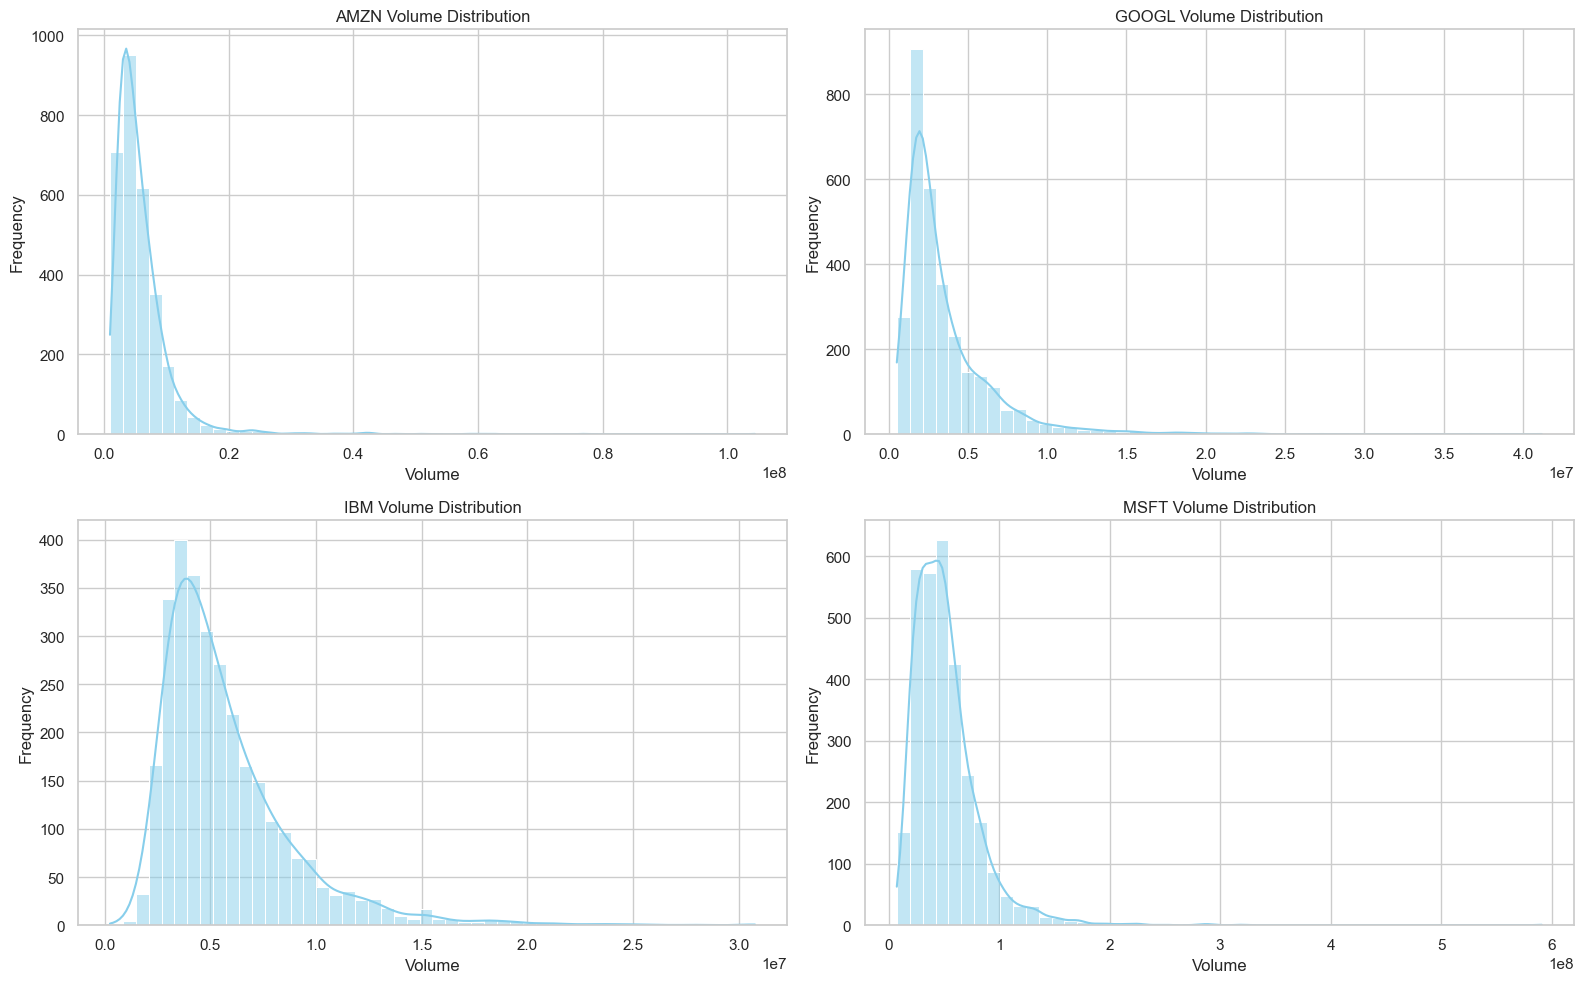

In [58]:
# Frequency distribution of volumes


sns.set(style="whitegrid")
stocks = all_stocks_df['Stock'].unique()

# Plottiing histograms for volume per stock
plt.figure(figsize=(16, 10))
for i, stock in enumerate(stocks):
    plt.subplot(2, 2, i + 1)
    sns.histplot(
        data=all_stocks_df[all_stocks_df['Stock'] == stock],
        x='Volume',
        bins=50,
        kde=True,
        color='skyblue'
    )
    plt.title(f'{stock} Volume Distribution')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

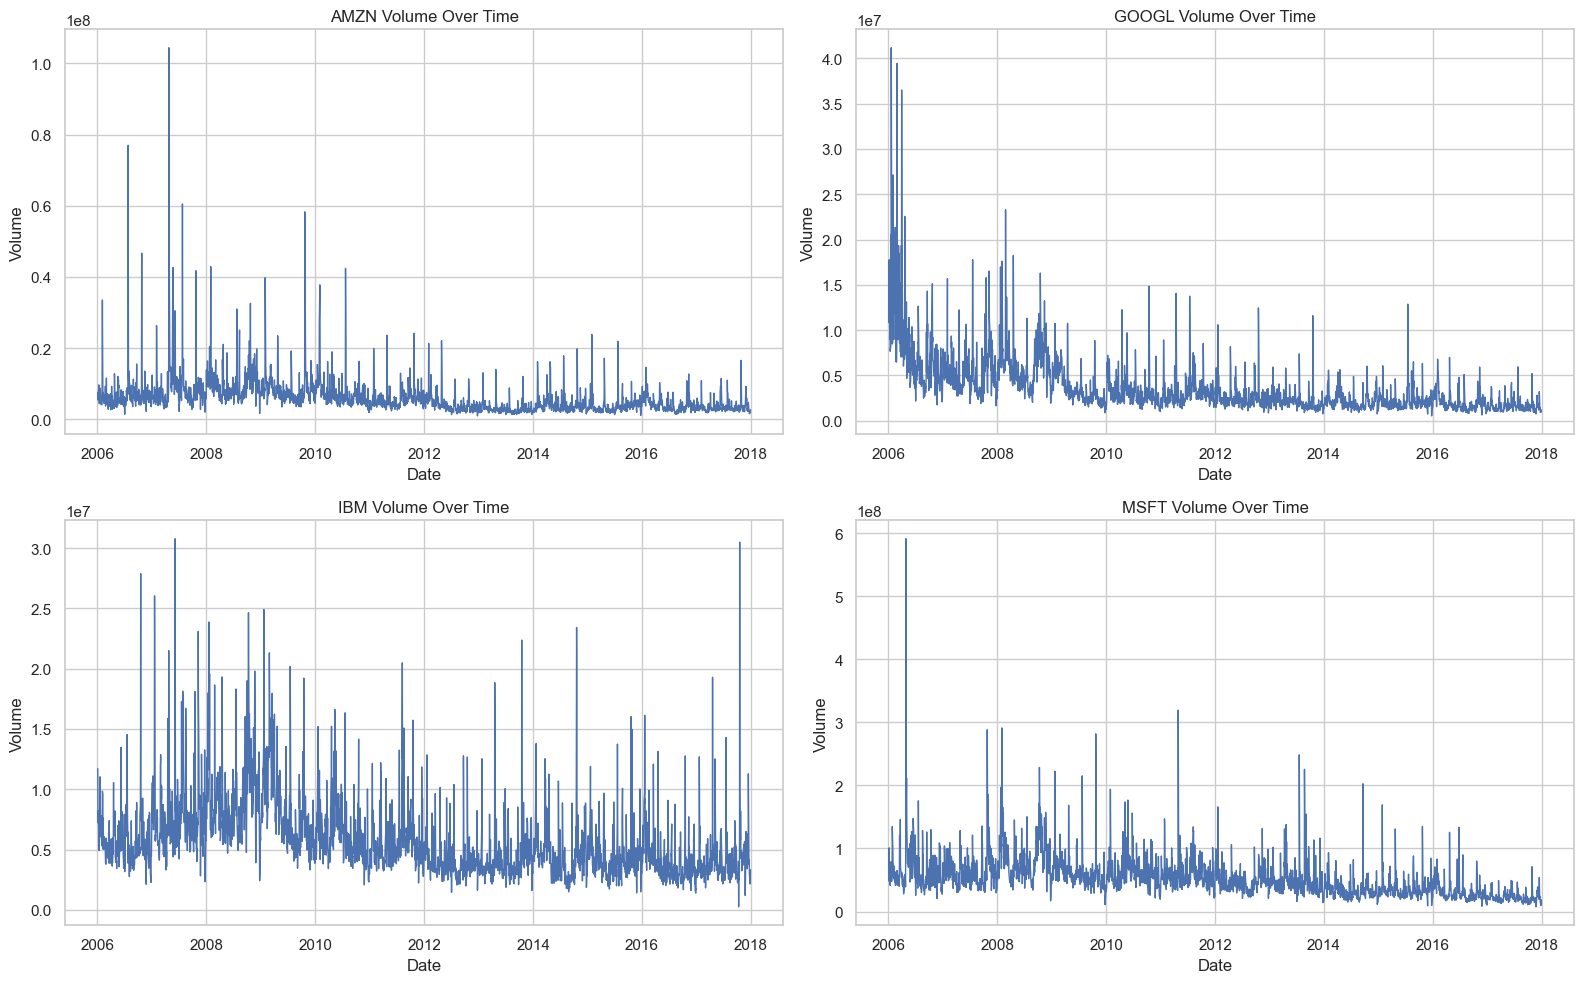

In [59]:
# Stock volume variation over time

plt.figure(figsize=(16, 10))
for i, stock in enumerate(stocks):
    plt.subplot(2, 2, i + 1)
    df = all_stocks_df[all_stocks_df['Stock'] == stock]
    plt.plot(df['Date'], df['Volume'], label=f'{stock} Volume', linewidth=1)
    plt.title(f'{stock} Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.grid(True)
plt.tight_layout()
plt.show()

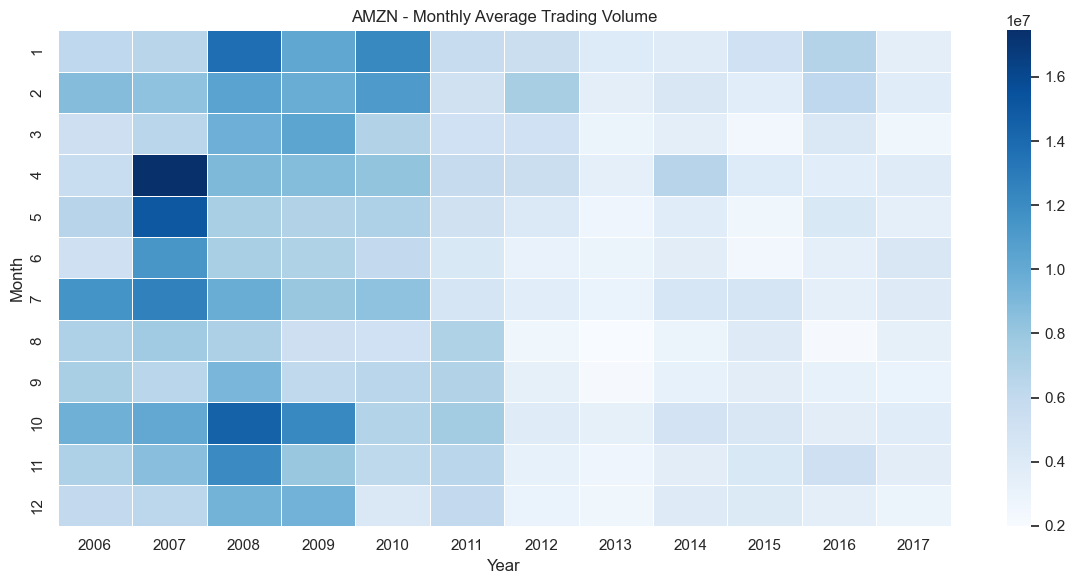

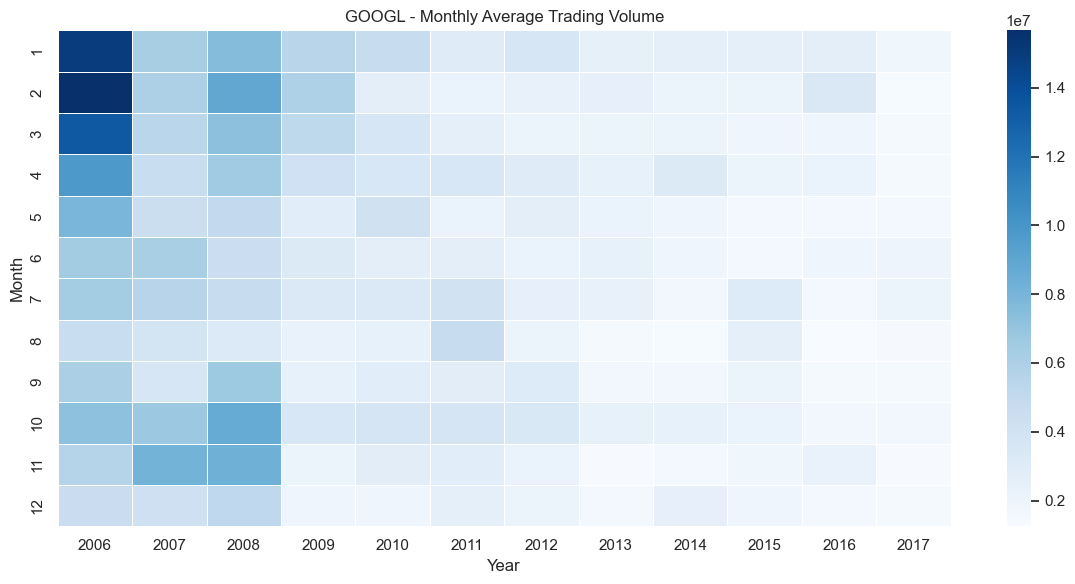

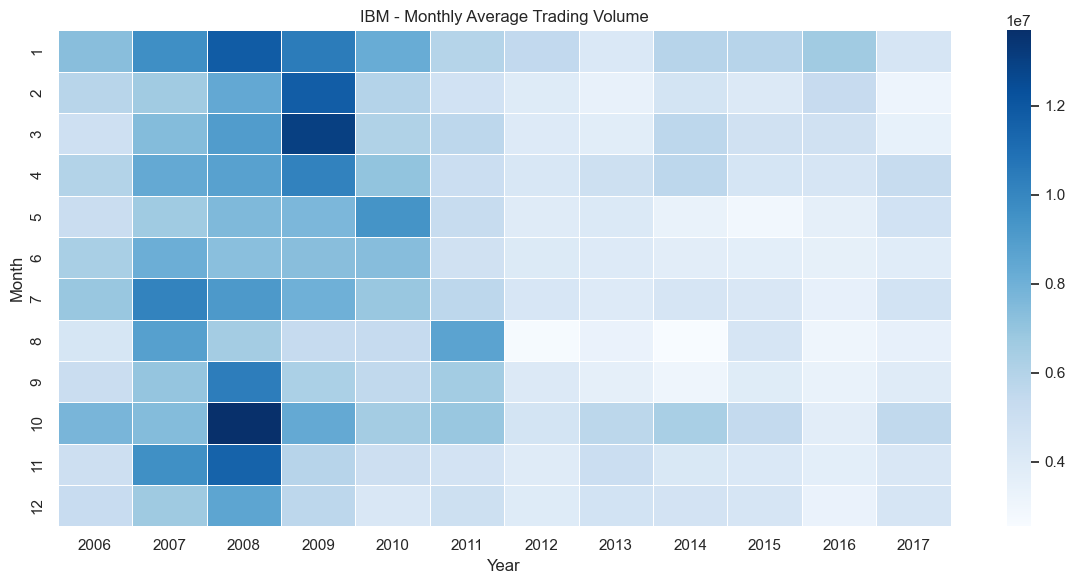

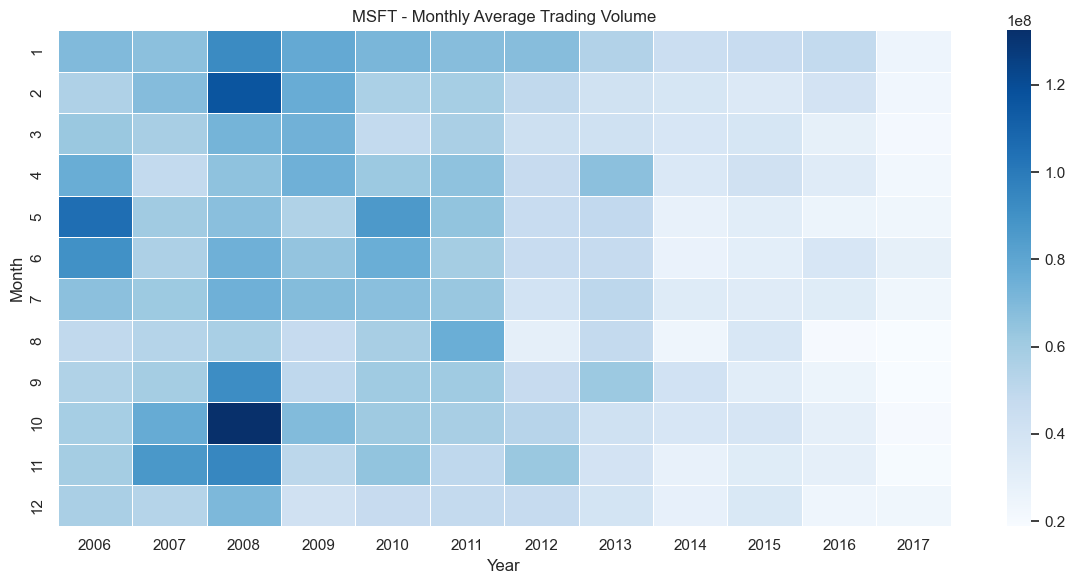

In [60]:
all_stocks_df['Year'] = all_stocks_df['Date'].dt.year
all_stocks_df['Month'] = all_stocks_df['Date'].dt.month

# Unique stock symbols
stocks = all_stocks_df['Stock'].unique()

# Plot heatmap for each stock
for stock in stocks:
    # Filter data for the stock
    df = all_stocks_df[all_stocks_df['Stock'] == stock]

    # Create pivot table: average volume by (Month x Year)
    volume_heatmap = df.pivot_table(values='Volume', index='Month', columns='Year', aggfunc='mean')

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(volume_heatmap, cmap="Blues", linewidths=0.5, annot=False)
    plt.title(f'{stock} - Monthly Average Trading Volume')
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.tight_layout()
    plt.show()

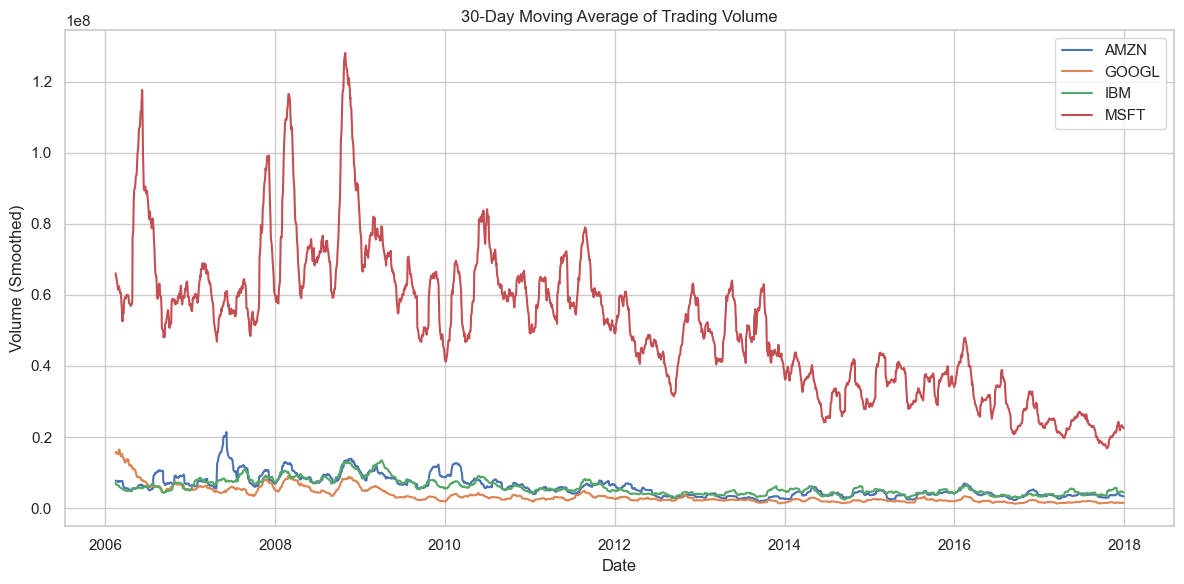

In [61]:
plt.figure(figsize=(12, 6))
for stock in all_stocks_df['Stock'].unique():
    df = all_stocks_df[all_stocks_df['Stock'] == stock].copy()
    df['Volume_MA'] = df['Volume'].rolling(window=30).mean()  # 30-day moving average
    plt.plot(df['Date'], df['Volume_MA'], label=stock)

plt.title('30-Day Moving Average of Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume (Smoothed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

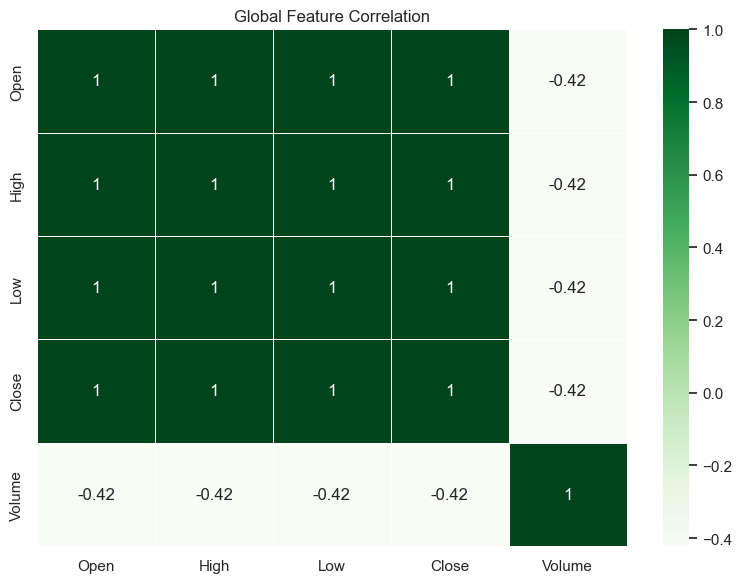

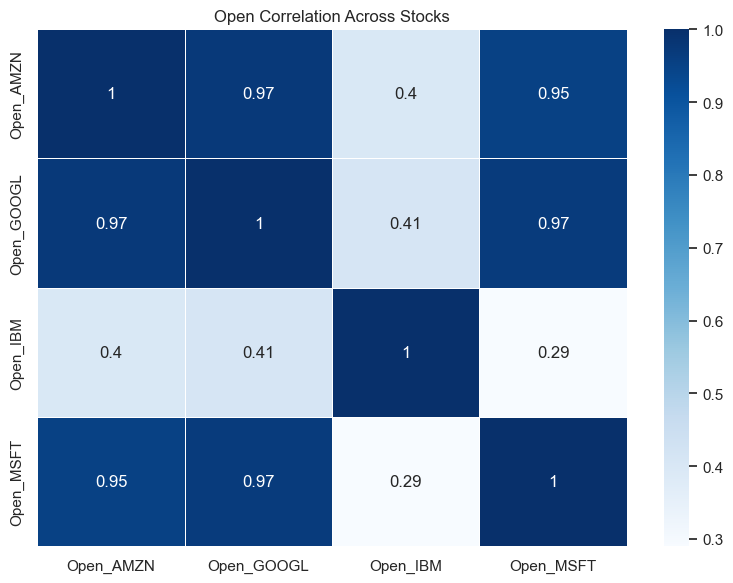

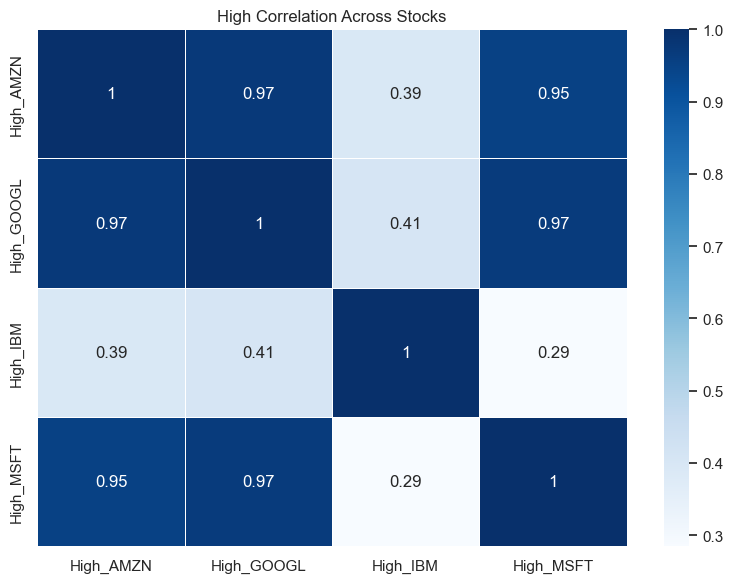

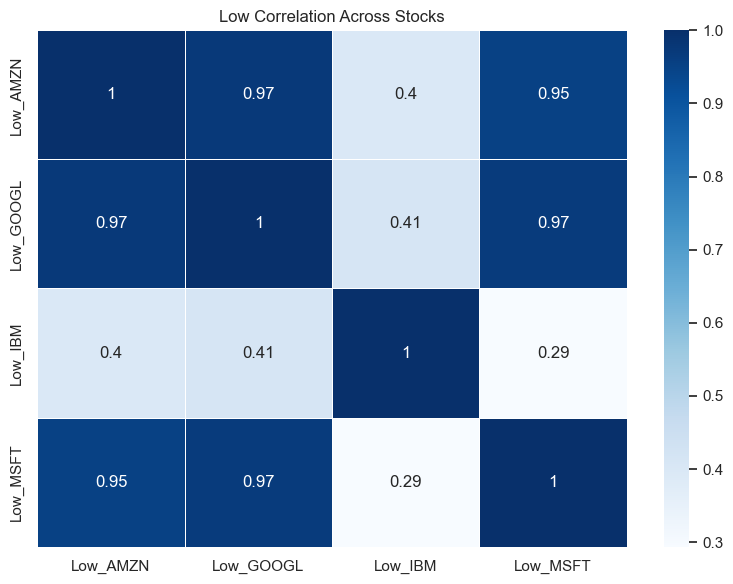

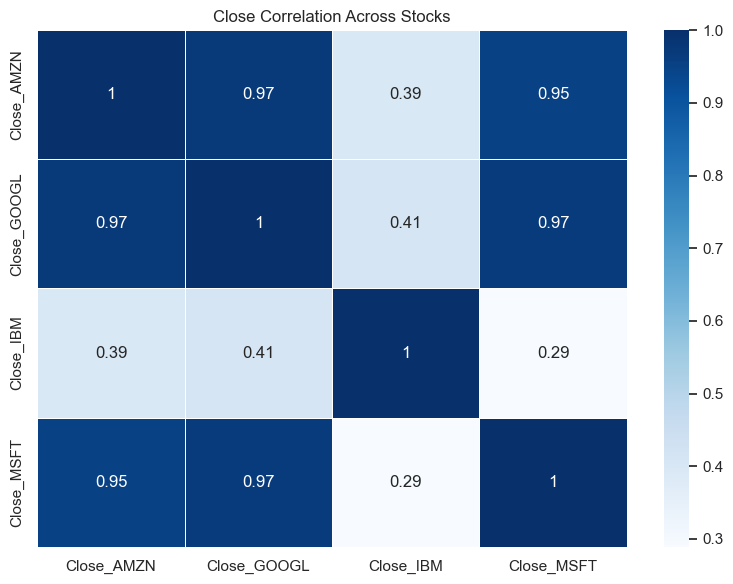

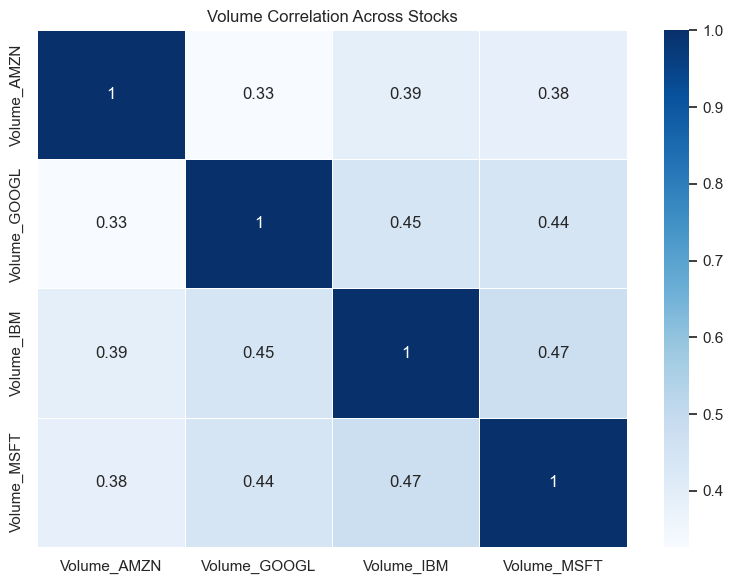

In [62]:
# Analyse correlations

# Define feature columns to analyze
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# GLOBAL CORRELATION
global_corr = all_stocks_df[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(global_corr, annot=True, cmap='Greens', linewidths=0.5)
plt.title('Global Feature Correlation')
plt.tight_layout()
plt.show()


#corealtion across stocks
pivoted = all_stocks_df.pivot(index='Date', columns='Stock')[['Open', 'High', 'Low', 'Close', 'Volume']]
pivoted.columns = [f"{feature}_{stock}" for feature, stock in pivoted.columns]

# Loop through each feature and compare across stocks
for feature in features:
    feature_cols = [col for col in pivoted.columns if col.startswith(feature)]
    corr = pivoted[feature_cols].corr()

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='Blues', linewidths=0.5)
    plt.title(f'{feature} Correlation Across Stocks')
    plt.tight_layout()
    plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [63]:
# Define a function that divides the data into windows and generates target variable values for each window


def create_windowed_data(df, window_size=3, step_size=1, target_stocks=['IBM']):

    X = []
    y = []

    feature_df = df.pivot(index='Date', columns='Stock')[['Open', 'High', 'Low', 'Close', 'Volume']]
    close_df = df.pivot(index='Date', columns='Stock', values='Close')
    
    feature_df.columns = [f"{var}_{stock}" for var, stock in feature_df.columns]


    feature_df = feature_df.sort_index()
    close_df = close_df.sort_index()

    for i in range(0, len(feature_df) - window_size, step_size):
        window = feature_df.iloc[i: i + window_size].values
        X.append(window)

        target_close = close_df.iloc[i + window_size][target_stocks].values
        y.append(target_close if len(target_stocks) > 1 else target_close[0])

    return np.array(X), np.array(y)



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [64]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    
    n_samples, window_size, n_features = X.shape
    X_reshaped = X.reshape(n_samples * window_size, n_features)
    
    x_scaler = StandardScaler()
    x_scaler.partial_fit(X_reshaped)
    scaled_X = x_scaler.transform(X_reshaped).reshape(n_samples, window_size, n_features)

    y_scaler = StandardScaler()
    
    if y.ndim == 1:
        y = y.reshape(-1, 1)
        
    y_scaler.partial_fit(y)
    scaled_y = y_scaler.transform(y)

    return scaled_X, scaled_y, x_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [92]:
# Define a function to create input and output data points from the master DataFrame


def prepare_data_for_rnn(df, target_stocks, window_size=5, step_size=1, train_ratio=0.7):

    # Create windowed input/output pairs
    X_raw, y_raw = create_windowed_data(df, window_size, step_size, target_stocks)

    # Scale entire data
    X_scaled, y_scaled, _, y_scaler = scale_windowed_data(X_raw, y_raw)

    # Train-test split using sklearn
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled,
        train_size=train_ratio,
        shuffle=False
    )

    return X_train, y_train, X_test, y_test, y_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

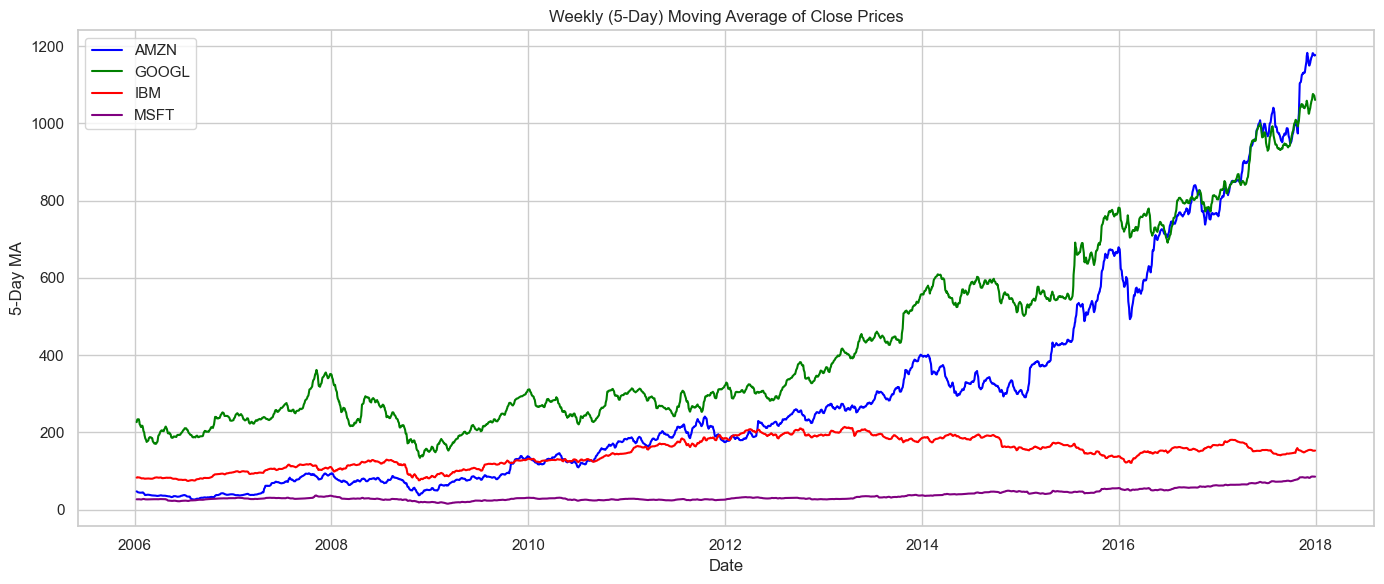

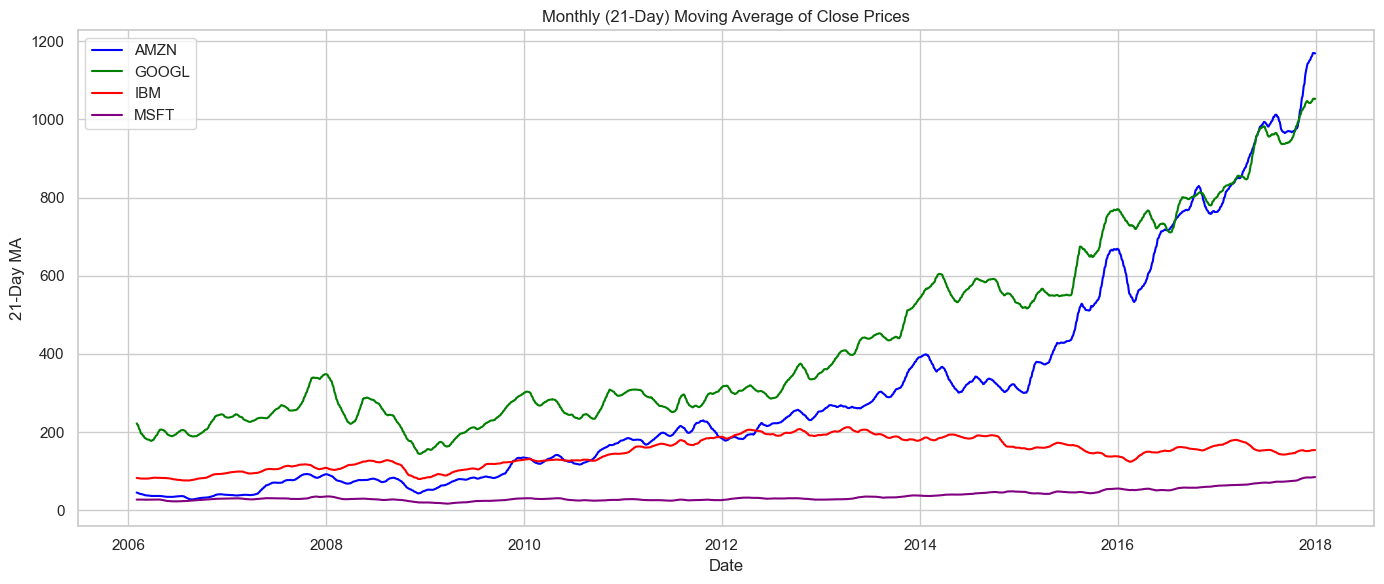

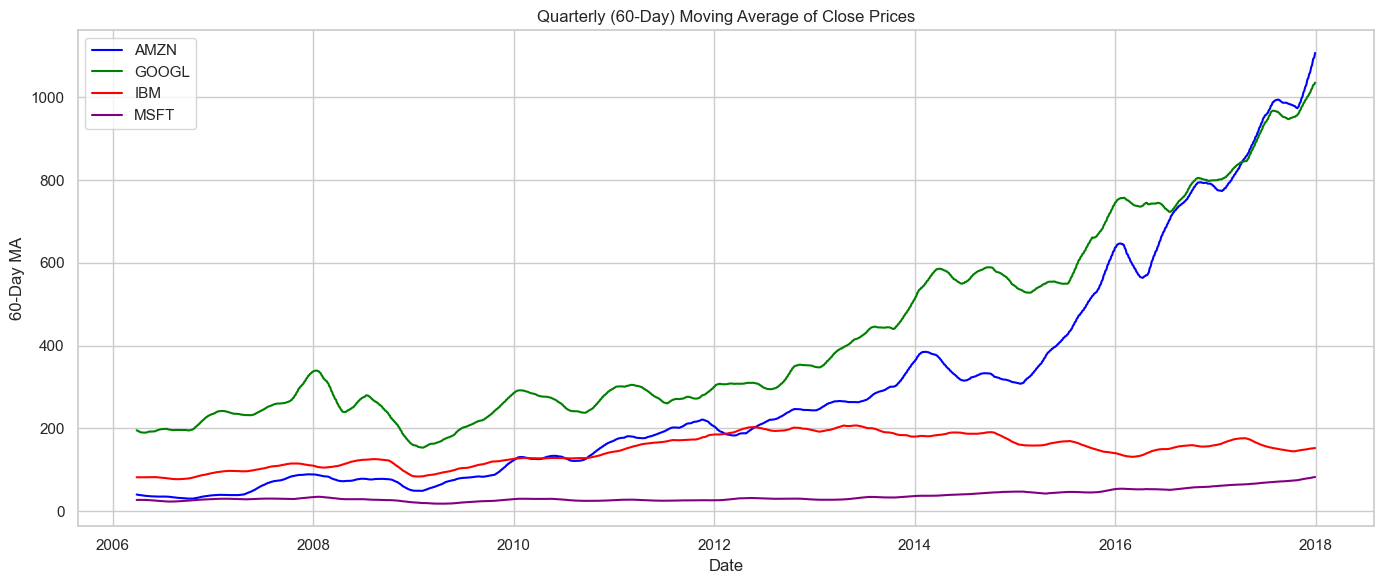

In [93]:
# Checking for patterns in different sequence lengths

stocks = all_stocks_df['Stock'].unique()
colors = ['blue', 'green', 'red', 'purple']
color_map = dict(zip(stocks, colors))

# Initialize a dictionary to hold MA data
ma_data = {
    'Weekly': {},    # 5-day
    'Monthly': {},   # 21-day
    'Quarterly': {}  # 60-day
}

# Calculate moving averages for each stock
for stock in stocks:
    df = all_stocks_df[all_stocks_df['Stock'] == stock].copy()
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    
    ma_data['Weekly'][stock] = df['Close'].rolling(window=5).mean()
    ma_data['Monthly'][stock] = df['Close'].rolling(window=21).mean()
    ma_data['Quarterly'][stock] = df['Close'].rolling(window=60).mean()

# Plot function for each MA group
def plot_ma(ma_type, title, ylabel):
    plt.figure(figsize=(14, 6))
    for stock in stocks:
        plt.plot(ma_data[ma_type][stock], label=f'{stock}', color=color_map[stock])
    
    plt.title(f'{title} Moving Average of Close Prices')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot 
plot_ma('Weekly', 'Weekly (5-Day)', '5-Day MA')
plot_ma('Monthly', 'Monthly (21-Day)', '21-Day MA')
plot_ma('Quarterly', 'Quarterly (60-Day)', '60-Day MA')

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [118]:
# Create data instances from the master data frame using decided window size and window stride

# Decided Parameters
target_stocks = ['IBM']      
window_size = 21               
step_size = 1                  
train_ratio = 0.7              

# Create training and testing sets
X_train, y_train, X_test, y_test, y_scaler = prepare_data_for_rnn(
    all_stocks_df,
    target_stocks=target_stocks,
    window_size=window_size,
    step_size=step_size,
    train_ratio=train_ratio
)

In [119]:
# Check the number of data points generated
print("Total number of datapoints:", len(X_train) + len(X_test))
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))


Total number of datapoints: 2998
Number of training samples: 2098
Number of testing samples: 900


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [120]:
# Check if the datasets are compatible inputs to neural networks

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


num_features = X_train.shape[2]
print("Number of input features:", num_features)

#Ensure that the dtype is float for neural networks
print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)

Shapes:
X_train: (2098, 21, 20)
y_train: (2098, 1)
X_test: (900, 21, 20)
y_test: (900, 1)
Number of input features: 20
X_train dtype: float64
y_train dtype: float64


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [121]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_simple_rnn_model(input_shape, output_dim=1, rnn_units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=rnn_units, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [122]:
# Find an optimal configuration of simple RNN

# Define hyperparameter grid 
rnn_units_list = [32, 64]
dense_units_list = [16, 32, 64]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
batch_sizes = [32]
epochs_list = [30]

# Generate all combinations
param_grid = list(itertools.product(rnn_units_list, dense_units_list, dropout_rates,
                                    learning_rates, batch_sizes, epochs_list))


# Training and evaluation function
def train_and_evaluate_model(X_train, y_train, X_val, y_val,
                             rnn_units, dense_units, dropout_rate,
                             learning_rate, batch_size, epochs):
    
    input_shape = X_train.shape[1:]

    model = build_simple_rnn_model(
        input_shape=input_shape,
        rnn_units=rnn_units,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop,reduce_lr]
    )

    return min(history.history['val_loss']), model


# Tuning function
def rnn_hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid):
    print("Starting hyperparameter search...\n")

    best_loss = float('inf')
    best_params = None
    best_model = None

    for rnn_units, dense_units, dropout_rate, lr, bs, ep in param_grid:
        val_loss, model = train_and_evaluate_model(
            X_train, y_train,
            X_val, y_val,
            rnn_units, dense_units, dropout_rate,
            lr, bs, ep
        )

        print(f"Tested: RNN Units={rnn_units}, Dense Units={dense_units}, Dropout Rate={dropout_rate}, Learning Rate={lr}, "
              f"Batch Size={bs}, Epochs={ep}, val_loss={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = (rnn_units, dense_units, dropout_rate, lr, bs, ep)
            best_model = model

    return best_model, best_params, best_loss

In [71]:
# Find the best configuration based on evaluation metrics

best_model, best_params, best_loss = rnn_hyperparameter_tuning(X_train, y_train, X_test, y_test, param_grid)

# Final result
print("\nBest Hyperparameters:")
print(f"RNN Units   : {best_params[0]}")
print(f"Dense Units : {best_params[1]}")
print(f"Dropout     : {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Batch Size  : {best_params[4]}")
print(f"Epochs      : {best_params[5]}")
print(f"Val Loss    : {best_loss:.4f}")

Starting hyperparameter search...

Tested: RNN Units=32, Dense Units=16, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0162
Tested: RNN Units=32, Dense Units=16, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0629
Tested: RNN Units=32, Dense Units=16, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.1304
Tested: RNN Units=32, Dense Units=16, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0108
Tested: RNN Units=32, Dense Units=32, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0293
Tested: RNN Units=32, Dense Units=32, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.4878
Tested: RNN Units=32, Dense Units=32, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.1670
Tested: RNN Units=32, Dense Units=32, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0257
Tested: R

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [130]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Best hyperparameters from tuning
best_rnn_units = best_params[0]
best_dense_units = best_params[1]
best_dropout = best_params[2]
best_learning_rate = best_params[3]
best_batch_size = best_params[4]
best_epochs = best_params[5]

# Define input shape
input_shape = X_train.shape[1:]

# Build the final model using best hyperparameters
final_model = build_simple_rnn_model(
    input_shape=input_shape,
    rnn_units=best_rnn_units,
    dense_units=best_dense_units,
    dropout_rate=best_dropout,
    learning_rate=best_learning_rate
)

# Print model architecture
final_model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model on the full training set
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),           
    epochs=best_epochs,
    batch_size=best_batch_size,
    callbacks=[early_stop,reduce_lr],
    verbose=1
)

# Evaluate performance
train_loss = final_model.evaluate(X_train, y_train, verbose=0)
val_loss = final_model.evaluate(X_test, y_test, verbose=0)

# Print summary
print("\nFinal Model Performance:")
print(f"Training Loss   : {train_loss:.4f}")
print(f"Validation Loss : {val_loss:.4f}")

Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_101 (SimpleRNN)      │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1317 - val_loss: 0.5324 - learning_rate: 5.0000e-04
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3726 - val_loss: 0.5670 - learning_rate: 5.0000e-04
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2344 - val_loss: 0.5793 - learning_rate: 5.0000e-04
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2010 - val_loss: 0.4161 - learning_rate: 5.0000e-04
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1708 - val_loss: 0.4429 - learning_rate: 5.0000e-04
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1374 - val_loss: 0.3350 - learning_rate: 5.0000e-04
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1374 - val_loss: 0.2636 - learning_rate: 5.0000e-04
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1325 - val_loss: 0.2979 - learning_rate: 5.0000e-04
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1250 - val_loss: 0.2547 - learning_ra

Plotting the actual vs predicted values

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


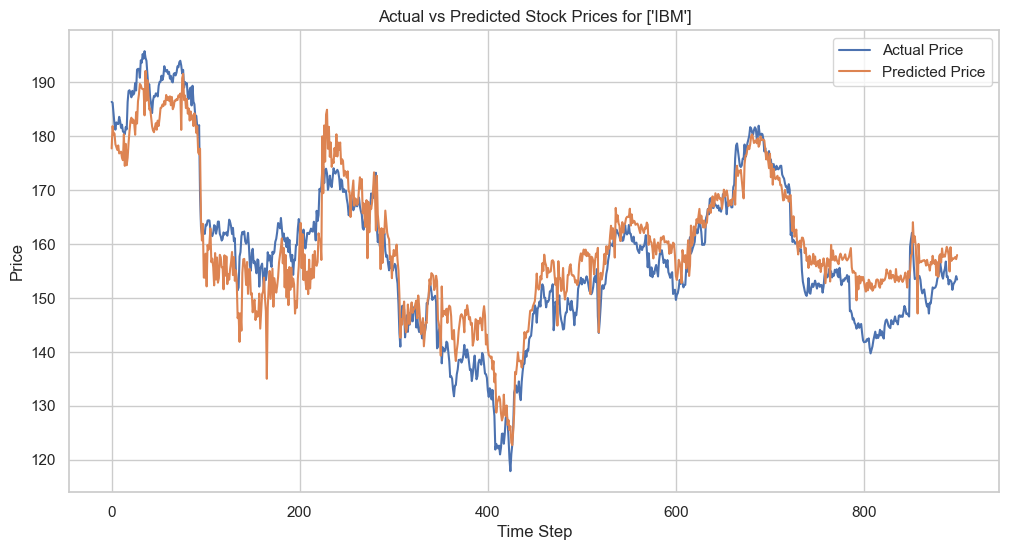

In [131]:
# Predict on the test data and plot

# Predict scaled values
y_pred_scaled = final_model.predict(X_test).flatten()

# Inverse transform both predicted and actual to original price scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title(f'Actual vs Predicted Stock Prices for {target_stocks}')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [132]:
### Compute the performance of the model on the testing data set


mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


print("Model Evaluation on Test Set:")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

Model Evaluation on Test Set:
MSE  = 33.1196
RMSE = 5.7550
MAE  = 4.8380
R²   = 0.8584


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [112]:
# # Define a function to create a model and specify default values for hyperparameters

def build_lstm_model(input_shape, output_dim=1, lstm_units=64, dense_units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    #LSTM layer
    model.add(LSTM(units=lstm_units, return_sequences=False, input_shape=input_shape))    
    model.add(Dropout(dropout_rate))    
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=output_dim, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [76]:
# Find an optimal configuration

# Define hyperparameter grid 
lstm_units_list = [32, 64, 128]
dense_units_list = [16, 32, 64]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
batch_sizes = [32]
epochs_list = [30]

# Generate all combinations
param_grid = list(itertools.product(lstm_units_list, dense_units_list, dropout_rates,
                                    learning_rates, batch_sizes, epochs_list))


# Training and evaluation function
def train_and_evaluate_model_lstm(X_train, y_train, X_val, y_val,
                             lstm_units, dense_units, dropout_rate,
                             learning_rate, batch_size, epochs):
    
    input_shape = X_train.shape[1:]

    model = build_lstm_model(
        input_shape=input_shape,
        lstm_units=lstm_units,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop,reduce_lr]
    )

    return min(history.history['val_loss']), model


# Tuning function
def rnn_hyperparameter_tuning_lstm(X_train, y_train, X_val, y_val, param_grid):
    print("Starting hyperparameter search...\n")

    best_loss = float('inf')
    best_params = None
    best_model = None

    for lstm_units, dense_units, dropout_rate, lr, bs, ep in param_grid:
        val_loss, model = train_and_evaluate_model_lstm(
            X_train, y_train,
            X_val, y_val,
            lstm_units, dense_units, dropout_rate,
            lr, bs, ep
        )

        print(f"Tested: LSTM Units={lstm_units}, Dense Units={dense_units}, Dropout Rate={dropout_rate}, Learning Rate={lr}, "
              f"Batch Size={bs}, Epochs={ep}, val_loss={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = (lstm_units, dense_units, dropout_rate, lr, bs, ep)
            best_model = model

    return best_model, best_params, best_loss


#Call tuning function
best_model_lstm, best_params_lstm, best_loss_lstm = rnn_hyperparameter_tuning_lstm(X_train, y_train, X_test, y_test, param_grid)

print("\nBest Hyperparameters:")
print(f"RNN Units   : {best_params_lstm[0]}")
print(f"Dense Units : {best_params_lstm[1]}")
print(f"Dropout     : {best_params_lstm[2]}")
print(f"Learning Rate: {best_params_lstm[3]}")
print(f"Batch Size  : {best_params_lstm[4]}")
print(f"Epochs      : {best_params_lstm[5]}")
print(f"Val Loss    : {best_loss:.4f}")



Starting hyperparameter search...

Tested: LSTM Units=32, Dense Units=16, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0193
Tested: LSTM Units=32, Dense Units=16, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0979
Tested: LSTM Units=32, Dense Units=16, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0243
Tested: LSTM Units=32, Dense Units=16, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0146
Tested: LSTM Units=32, Dense Units=32, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0295
Tested: LSTM Units=32, Dense Units=32, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0328
Tested: LSTM Units=32, Dense Units=32, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0341
Tested: LSTM Units=32, Dense Units=32, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.0861
T

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [133]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model


# Best hyperparameters from tuning
best_lstm_units = best_params_lstm[0]
best_dense_units = best_params_lstm[1]
best_dropout = best_params_lstm[2]
best_learning_rate = best_params_lstm[3]
best_batch_size = best_params_lstm[4]
best_epochs = best_params_lstm[5]

# Define input shape
input_shape = X_train.shape[1:]

# Build model
lstm_model = build_lstm_model(
    input_shape=input_shape,
    lstm_units=best_lstm_units,
    dense_units=best_dense_units,
    dropout_rate=best_dropout,
    learning_rate=best_learning_rate
)

lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train final model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),           
    epochs=30,
    batch_size=32,
    callbacks=[early_stop,reduce_lr],
    verbose=1
)

train_loss = lstm_model.evaluate(X_train, y_train, verbose=0)
val_loss = lstm_model.evaluate(X_test, y_test, verbose=0)


print("LSTM Model Performance:")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_102 (LSTM)                 │ (None, 128)            │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,609 (330.50 KB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.3435 - val_loss: 0.0248 - learning_rate: 5.0000e-04
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0290 - val_loss: 0.0273 - learning_rate: 5.0000e-04
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0231 - val_loss: 0.0338 - learning_rate: 5.0000e-04
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0209 - val_loss: 0.0201 - learning_rate: 5.0000e-04
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0166 - val_loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0171 - val_loss: 0.0236 - learning_rate: 5.0000e-04
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0164 - val_loss: 0.0181 - learning_rate: 5.0000e-04
Epoch 8/30
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0137
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0137 - val_loss: 

In [134]:
# Compute the performance of the model on the testing data set

#Predict scaled outputs
y_pred_scaled = lstm_model.predict(X_test)

#Inverse transform predictions and true values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

#Print results
print("Model Evaluation on Test Set:")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Model Evaluation on Test Set:
MSE  = 15.6501
RMSE = 3.9560
MAE  = 3.1048
R²   = 0.9331


Plotting the actual vs predicted values

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


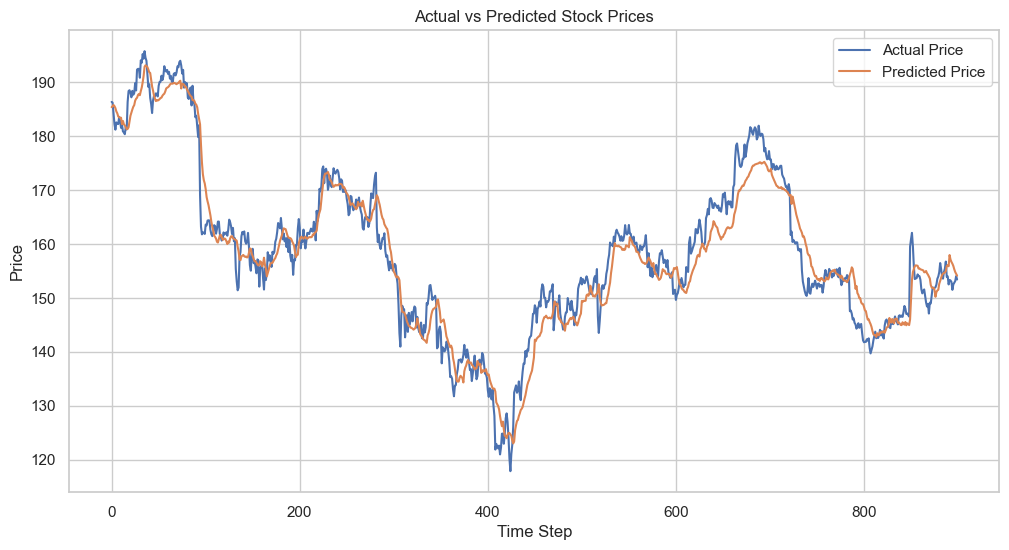

In [135]:
# Predict on the test data


#Predict scaled outputs
y_pred_scaled = lstm_model.predict(X_test)

#Inverse transform predictions and true values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)


plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [142]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter

window_size = 65
step_size = 5
target_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
target_stocks=target_names
test_ratio = 0.2
train_ratio=1-test_ratio

# Create training and testing sets
X_train, y_train, X_test, y_test, y_scaler = prepare_data_for_rnn(
    all_stocks_df,
    target_stocks=target_stocks,
    window_size=window_size,
    step_size=step_size,
    train_ratio=train_ratio
)


In [143]:
# Check the number of data points generated
print("Total number of datapoints:", len(X_train) + len(X_test))
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Total number of datapoints: 591
Number of training samples: 472
Number of testing samples: 119
Shapes:
X_train: (472, 65, 20)
y_train: (472, 4)
X_test: (119, 65, 20)
y_test: (119, 4)


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [144]:
# Find an optimal configuration of simple RNN


rnn_units_list = [ 256, 512]
dense_units_list = [ 128, 256, 512]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
batch_sizes = [32]
epochs_list = [30]

# Generate all combinations
param_grid = list(itertools.product(rnn_units_list, dense_units_list, dropout_rates,
                                    learning_rates, batch_sizes, epochs_list))


# Training and evaluation function
def train_and_evaluate_model(X_train, y_train, X_val, y_val,
                             rnn_units, dense_units, dropout_rate,
                             learning_rate, batch_size, epochs):
    
    input_shape = X_train.shape[1:]
    output_dim = y_train.shape[1] if y_train.ndim > 1 else 1

    model = build_simple_rnn_model(
        input_shape=input_shape,
        output_dim=output_dim,
        rnn_units=rnn_units,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop,reduce_lr]
    )

    return min(history.history['val_loss']), model


# Tuning function
def rnn_hyperparameter_tuning(X_train, y_train, X_val, y_val, param_grid):
    print("Starting hyperparameter search...\n")

    best_loss = float('inf')
    best_params = None
    best_model = None

    for rnn_units, dense_units, dropout_rate, lr, bs, ep in param_grid:
        val_loss, model = train_and_evaluate_model(
            X_train, y_train,
            X_val, y_val,
            rnn_units, dense_units, dropout_rate,
            lr, bs, ep
        )

        print(f"Tested: RNN Units={rnn_units}, Dense Units={dense_units}, Dropout Rate={dropout_rate}, Learning Rate={lr}, "
              f"Batch Size={bs}, Epochs={ep}, val_loss={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = (rnn_units, dense_units, dropout_rate, lr, bs, ep)
            best_model = model

    return best_model, best_params, best_loss

In [145]:
# Find the best configuration

best_model, best_params, best_loss = rnn_hyperparameter_tuning(X_train, y_train, X_test, y_test, param_grid)


# Final result
print("\nBest Hyperparameters:")
print(f"RNN Units   : {best_params[0]}")
print(f"Dense Units : {best_params[1]}")
print(f"Dropout     : {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Batch Size  : {best_params[4]}")
print(f"Epochs      : {best_params[5]}")
print(f"Val Loss    : {best_loss:.4f}")

Starting hyperparameter search...

Tested: RNN Units=256, Dense Units=128, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.2844
Tested: RNN Units=256, Dense Units=128, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.1508
Tested: RNN Units=256, Dense Units=128, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.1370
Tested: RNN Units=256, Dense Units=128, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.3227
Tested: RNN Units=256, Dense Units=256, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.1023
Tested: RNN Units=256, Dense Units=256, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.1555
Tested: RNN Units=256, Dense Units=256, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.0946
Tested: RNN Units=256, Dense Units=256, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=

In [149]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Best hyperparameters from tuning
best_rnn_units = best_params[0]
best_dense_units = best_params[1]
best_dropout = best_params[2]
best_learning_rate = best_params[3]
best_batch_size = best_params[4]
best_epochs = best_params[5]


input_shape = X_train.shape[1:]
output_dim = y_train.shape[1] if y_train.ndim > 1 else 1

# Build the final model using best hyperparameters
final_model = build_simple_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    rnn_units=best_rnn_units,
    dense_units=best_dense_units,
    dropout_rate=best_dropout,
    learning_rate=best_learning_rate
)

# Print model architecture
final_model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model on the full training set
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),           
    epochs=best_epochs,
    batch_size=best_batch_size,
    callbacks=[early_stop,reduce_lr],
    verbose=1
)

# Evaluate performance
train_loss = final_model.evaluate(X_train, y_train, verbose=0)
val_loss = final_model.evaluate(X_test, y_test, verbose=0)

# Print summary
print("\nFinal Model Performance:")
print(f"Training Loss   : {train_loss:.4f}")
print(f"Validation Loss : {val_loss:.4f}")

Model: "sequential_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_153 (SimpleRNN)      │ (None, 512)            │       272,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_256 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_513 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,076 (1.29 MB)

 Trainable params: 339,076 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.5276 - val_loss: 0.8634 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.1516 - val_loss: 0.5243 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.1049 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0892 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0735 - val_loss: 0.1983 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0590 - val_loss: 0.1169 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0558 - val_loss: 0.1385 - learning_rate: 0.0010
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0398 - val_loss: 0.1102 - learning_rate: 0.0010
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0329 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 10/30
15/15

In [150]:
# Compute the performance of the model on the testing data set


y_pred_scaled = final_model.predict(X_test)


y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


print("Model Evaluation on Test Set:")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Model Evaluation on Test Set:
MSE  = 3056.4432
RMSE = 55.2851
MAE  = 34.4567
R²   = 0.7557


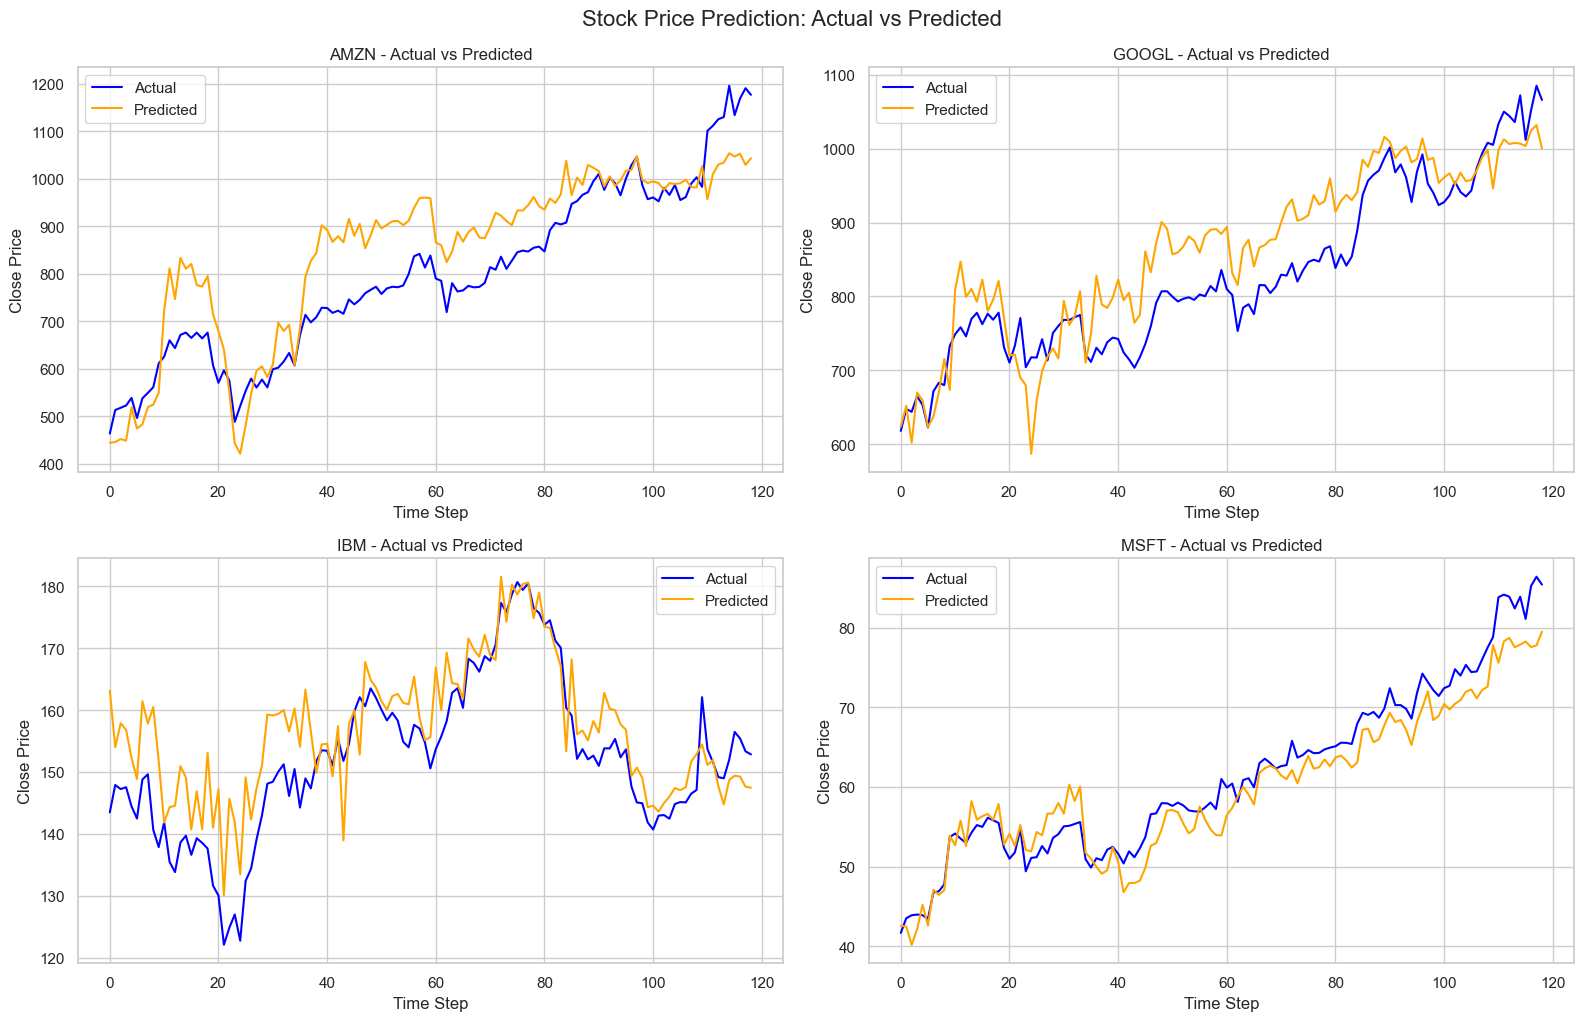

In [151]:
# Plotting the actual vs predicted values for all targets

plt.figure(figsize=(16, 10))
for i, stock in enumerate(target_stocks):
    plt.subplot(2, 2, i+1)
    plt.plot(y_true[:, i], label='Actual', color='blue')
    plt.plot(y_pred[:, i], label='Predicted', color='orange')
    plt.title(f'{stock} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Stock Price Prediction: Actual vs Predicted', fontsize=16, y=1.02)
plt.show()

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [38]:
# Find an optimal configuration of advanced RNN

lstm_units_list = [256, 512]
dense_units_list = [128, 256, 512]
dropout_rates = [0.3, 0.5]
learning_rates = [0.001, 0.0005]
batch_sizes = [32]
epochs_list = [30]

# Generate all combinations
param_grid = list(itertools.product(lstm_units_list, dense_units_list, dropout_rates,
                                    learning_rates, batch_sizes, epochs_list))


# Training and evaluation function
def train_and_evaluate_model_lstm(X_train, y_train, X_val, y_val,
                             lstm_units, dense_units, dropout_rate,
                             learning_rate, batch_size, epochs):
    
    input_shape = X_train.shape[1:]
    output_dim = y_train.shape[1] if y_train.ndim > 1 else 1
    
    model = build_lstm_model(
        input_shape=input_shape,
        output_dim=output_dim,
        lstm_units=lstm_units,
        dense_units=dense_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop,reduce_lr]
    )

    return min(history.history['val_loss']), model


# Tuning function
def rnn_hyperparameter_tuning_lstm(X_train, y_train, X_val, y_val, param_grid):
    print("Starting hyperparameter search...\n")

    best_loss = float('inf')
    best_params = None
    best_model = None

    for lstm_units, dense_units, dropout_rate, lr, bs, ep in param_grid:
        val_loss, model = train_and_evaluate_model_lstm(
            X_train, y_train,
            X_val, y_val,
            lstm_units, dense_units, dropout_rate,
            lr, bs, ep
        )

        print(f"Tested: LSTM Units={lstm_units}, Dense Units={dense_units}, Dropout Rate={dropout_rate}, Learning Rate={lr}, "
              f"Batch Size={bs}, Epochs={ep}, val_loss={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = (lstm_units, dense_units, dropout_rate, lr, bs, ep)
            best_model = model

    return best_model, best_params, best_loss




In [152]:
# Find the best configuration


best_model_lstm, best_params_lstm, best_loss_lstm = rnn_hyperparameter_tuning_lstm(X_train, y_train, X_test, y_test, param_grid)

print("\nBest Hyperparameters:")
print(f"RNN Units   : {best_params_lstm[0]}")
print(f"Dense Units : {best_params_lstm[1]}")
print(f"Dropout     : {best_params_lstm[2]}")
print(f"Learning Rate: {best_params_lstm[3]}")
print(f"Batch Size  : {best_params_lstm[4]}")
print(f"Epochs      : {best_params_lstm[5]}")
print(f"Val Loss    : {best_loss:.4f}")


Starting hyperparameter search...

Tested: LSTM Units=256, Dense Units=128, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.5777
Tested: LSTM Units=256, Dense Units=128, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.6390
Tested: LSTM Units=256, Dense Units=128, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.5647
Tested: LSTM Units=256, Dense Units=128, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.6195
Tested: LSTM Units=256, Dense Units=256, Dropout Rate=0.3, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.6108
Tested: LSTM Units=256, Dense Units=256, Dropout Rate=0.3, Learning Rate=0.0005, Batch Size=32, Epochs=30, val_loss=0.5716
Tested: LSTM Units=256, Dense Units=256, Dropout Rate=0.5, Learning Rate=0.001, Batch Size=32, Epochs=30, val_loss=0.5559
Tested: LSTM Units=256, Dense Units=256, Dropout Rate=0.5, Learning Rate=0.0005, Batch Size=32, Epochs=30, v

In [43]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model

best_lstm_units = best_params_lstm[0]
best_dense_units = best_params_lstm[1]
best_dropout = best_params_lstm[2]
best_learning_rate = best_params_lstm[3]
best_batch_size = best_params_lstm[4]
best_epochs = best_params_lstm[5]

# Define input shape
input_shape = X_train.shape[1:]
output_dim = y_train.shape[1] if y_train.ndim > 1 else 1
# Build model
lstm_model = build_lstm_model(
    input_shape=input_shape,
    output_dim=output_dim,
    lstm_units=best_lstm_units,
    dense_units=best_dense_units,
    dropout_rate=best_dropout,
    learning_rate=best_learning_rate
)

lstm_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)



# Train final model
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),           
    epochs=30,
    batch_size=32,
    callbacks=[early_stop,reduce_lr],
    verbose=1
)

train_loss = lstm_model.evaluate(X_train, y_train, verbose=0)
val_loss = lstm_model.evaluate(X_test, y_test, verbose=0)


print("LSTM Model Performance:")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_62 (LSTM)                  │ (None, 512)            │     1,091,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,157,764 (4.42 MB)

 Trainable params: 1,157,764 (4.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - loss: 0.1955 - val_loss: 0.3040 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 0.0182 - val_loss: 0.1996 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - loss: 0.0140 - val_loss: 0.0630 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0106 - val_loss: 0.0851 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - loss: 0.0089 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.0077 - val_loss: 0.0929 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 0.0077 - val_loss: 0.0673 - learning_rate: 0.0010
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 0.0077 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - loss: 0.0060 - val_loss: 0.0377 - learning_rate: 0.0010
Epoch 10/3

In [41]:
# Compute the performance of the model on the testing data set

y_pred_scaled = lstm_model.predict(X_test)


y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)


print("Model Evaluation on Test Set:")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"R²   = {r2:.4f}")

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/stepWARNING:tensorflow:5 out of the last 38 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002B3480C4F40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Model Evaluation on Test Set:
MSE  = 535.5972
RMSE = 23.1430
MAE  = 14.4217
R²   = 0.9262


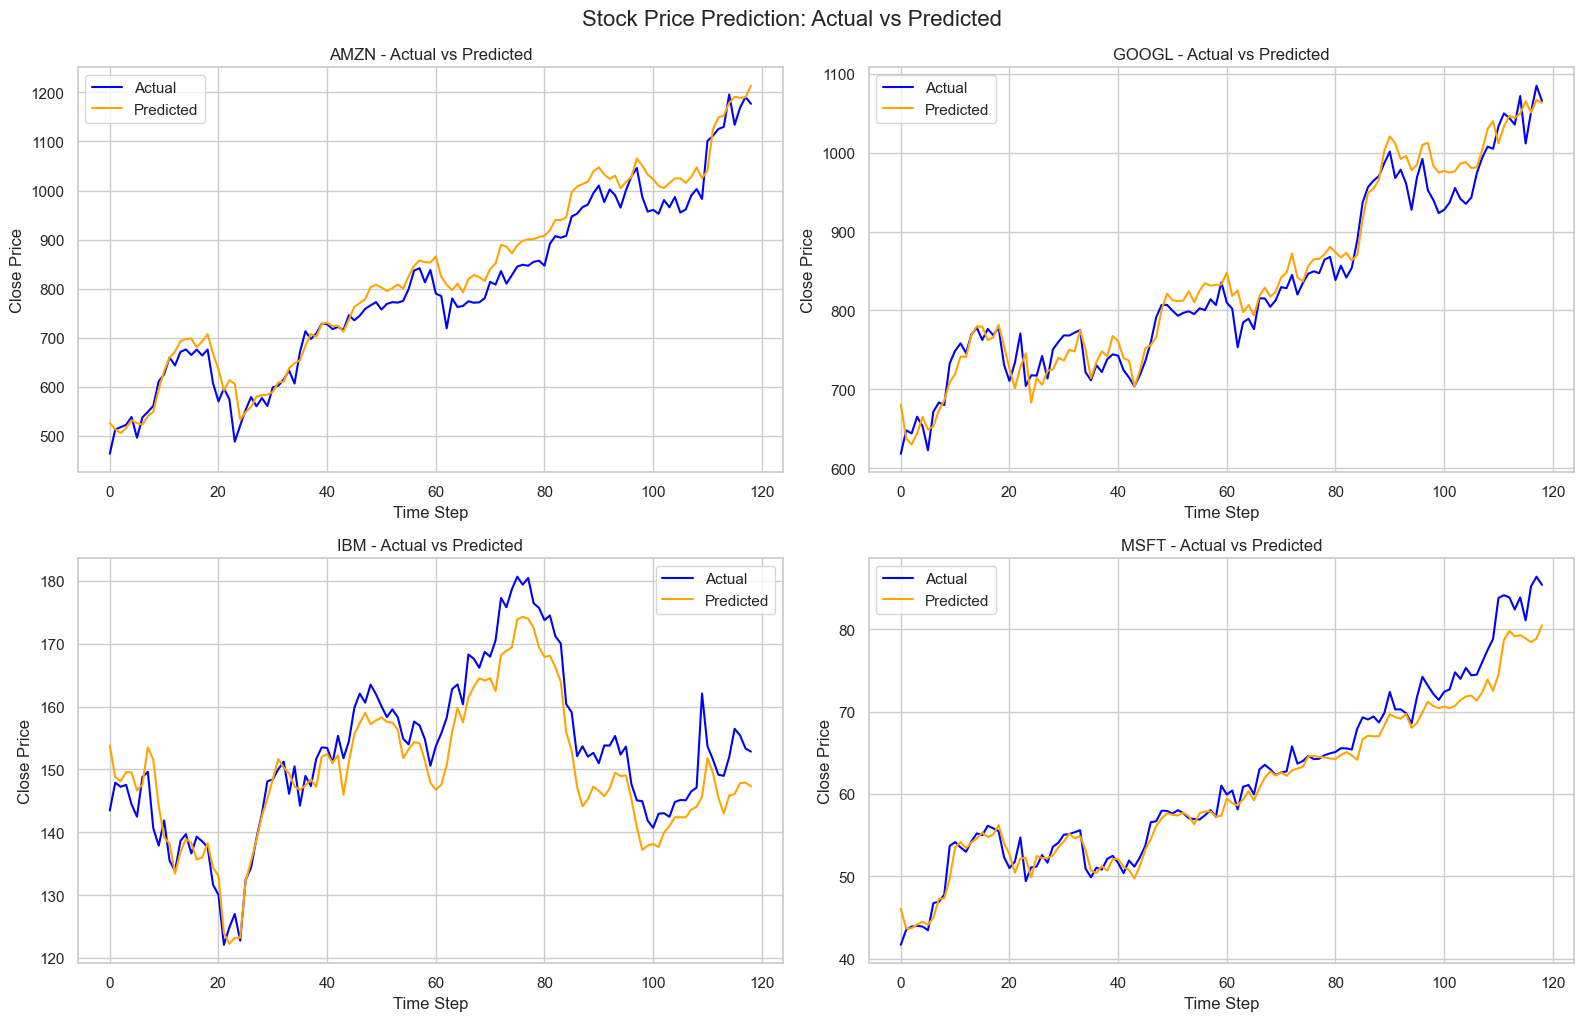

In [42]:
# Plotting the actual vs predicted values for all targets

plt.figure(figsize=(16, 10))
for i, stock in enumerate(target_stocks):
    plt.subplot(2, 2, i+1)
    plt.plot(y_true[:, i], label='Actual', color='blue')
    plt.plot(y_pred[:, i], label='Predicted', color='orange')
    plt.title(f'{stock} - Actual vs Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Stock Price Prediction: Actual vs Predicted', fontsize=16, y=1.02)
plt.show()

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

This project focused on forecasting stock closing prices using **Recurrent Neural Networks (RNN)** and **Long Short-Term Memory (LSTM)** architectures, applied to major stocks: **AMZN, GOOGL, IBM, and MSFT**. The study explored both **single-stock** (IBM) and **multi-stock** (all four) prediction tasks using windowed time-series data and comprehensive hyperparameter tuning.


## Key Insights and Observations

### **Single Target: IBM Close Price**

#### Simple RNN  
- **Best Hyperparameters:**  
  - RNN Units: 32  
  - Dense Units: 16  
  - Dropout: 0.5  
  - Learning Rate: 0.0005  
  - Batch Size: 32  
  - Epochs: 30  
- **Validation Loss:** 0.0238  
- **Test Results:**  
  - MSE: 33.1196  
  - RMSE: 5.7550  
  - MAE: 4.8380  
  - R²: 0.8584  

#### LSTM (Advanced RNN)  
- **Best Hyperparameters:**  
  - RNN Units: 128  
  - Dense Units: 64  
  - Dropout: 0.3  
  - Learning Rate: 0.0005  
  - Batch Size: 32  
  - Epochs: 30  
- **Validation Loss:** 0.0113  
- **Test Results:**  
  - MSE: 15.6501  
  - RMSE: 3.9560  
  - MAE: 3.1048  
  - R²: 0.9331  



### **Multiple Target: Multi-stock Close Prices**

#### Simple RNN  
- **Best Hyperparameters:**  
  - RNN Units: 512  
  - Dense Units: 128  
  - Dropout: 0.5  
  - Learning Rate: 0.001  
  - Batch Size: 32  
  - Epochs: 30  
- **Validation Loss:** 0.0726  
- **Test Results:**  
  - MSE: 3056.4432  
  - RMSE: 55.2851  
  - MAE: 34.4567  
  - R²: 0.7557  

#### LSTM (Advanced RNN)  
- **Best Hyperparameters:**  
  - RNN Units: 512  
  - Dense Units: 128  
  - Dropout: 0.3  
  - Learning Rate: 0.001  
  - Batch Size: 32  
  - Epochs: 30  
- **Validation Loss:** 0.0251  
- **Test Results:**  
  - MSE: 535.5972  
  - RMSE: 23.1430  
  - MAE: 14.4217  
  - R²: 0.9262  



## Final Outcomes Summary:

| Model Type        | Scope         | RMSE     | MAE      | R²     | Notes                                 |
|-------------------|---------------|----------|----------|--------|---------------------------------------|
| Simple RNN        | Single Stock  | 5.7550   | 4.8380   | 0.8584 | Performs well with fewer parameters   |
| LSTM              | Single Stock  | 3.9560   | 3.1048   | 0.9331 | Significantly better accuracy         |
| Simple RNN        | Multi-Stock   | 55.2851  | 34.4567  | 0.7557 | Struggles with multi-series complexity|
| LSTM              | Multi-Stock   | 23.1430  | 14.4217  | 0.9262 | Excels at capturing cross-series trends|


### Conclusion:

- **Simple RNNs** are effective for **single-stock forecasting**, offering good accuracy with a minimal architecture.
- **LSTM models** outperform in both single and multi-stock tasks, especially when modeling complex inter-stock dependencies.
- The **LSTM for multi-stock** prediction yielded the **highest accuracy** and **lowest error**, with an R² of **0.9262** on the test set.
- Using a **longer input window** (up to 65 timesteps) and **stride of 5** was beneficial in capturing **long-term temporal patterns**, particularly in the multi-stock setting.
- Ultimately, **model selection should be aligned with task complexity**: use **Simple RNNs for lightweight single-output predictions**, and **LSTMs for rich, multi-output temporal modeling**.
